In [2]:
%matplotlib inline

# PyTorch imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Categorical
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Grayscale, ToPILImage
#import onnx
#from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
#from onnx2pytorch import ConvertModel

# Auxiliary Python imports
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import deque, namedtuple

## Gym imports
import gym
import gym_jumping_task

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Testing the environment

In [4]:
env = gym_jumping_task.envs.JumpTaskEnv()
ACTION_SPACE = env.nb_actions
floor_height = 10
obstacle_pos = 30
state = env._reset(floor_height=floor_height, obstacle_position=obstacle_pos)

c:\Users\Sarrg\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (60, 60)
  logger.warn(


In [5]:
print(state.shape)

(60, 60)


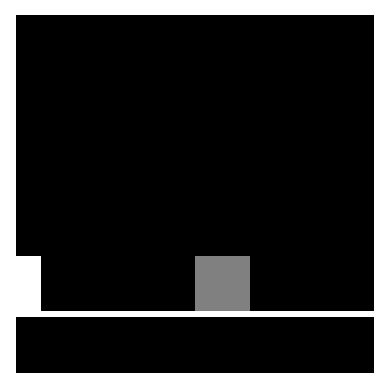

In [6]:
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')

## Define Expert policy

In [7]:
class Expert():
    def __init__(self, env: gym_jumping_task.envs.JumpTaskEnv):
        self.env = env
    
    def select_action(self, state=None):
        if self.env.agent_pos_x + 14 == self.env.obstacle_position:
            return 1
        return 0

Score: 57
Game Won


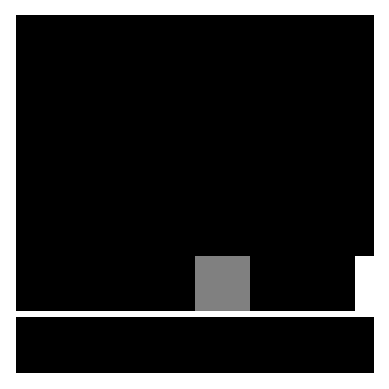

In [8]:
env.reset()
expert = Expert(env)
done = False
score = 0
while not done:
    a = expert.select_action()
    state, reward, done, _ = env.step(a)
    score += reward
print("Score:", score)
print("Game", "Won" if reward == 2 else "Lost")
plt.axis('off')
plt.imshow(state, cmap='gray', origin='lower')
plt.show()

## Generate and store demonstrations played by the expert

In [9]:
#Transition = namedtuple('Transition', ['state', 'action', 'rewards', 'next_state', 'done'])
Transition = namedtuple('Transition', ['state', 'action'])

class Episode(object):
    def __init__(self):
        self.transitions = []
        
    def __len__(self):
        return len(self.transitions)
    
    def append(self, transition):
        self.transition.append(transition)
        
    def __getitem__(self, index):
        return self.transitions[index]


class ReplayBuffer(object):
    def __init__(self, capacity=0):
        self.buffer = []
        self._next = 0
        self.capacity = capacity
    
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        return self.buffer[index]
    
    def add(self, episode):
        if self.capacity != 0 and len(self) == self.capacity:
            self.buffer[self._next] = episode
            self._next = (self._next+1)%self.capacity
        else:
            self.buffer.extend(episode)
        
    def save(self, path):
        np.savez_compressed(path, np.asanyarray(self.buffer, dtype='object'))
    
    def load(self, path):
        file = np.load(path, allow_pickle=True)
        self.buffer = file.f.arr_0
        


In [12]:
n_episodes = 250

env = gym_jumping_task.envs.JumpTaskEnv()
buffer = ReplayBuffer()
for e in tqdm(range(n_episodes)):
    episode = []
    env.reset()
    done = False
    while not done:
        a = expert.select_action()
        episode.append(Transition(state, a))
        state, reward, done, _ = env.step(a)
    buffer.add(episode)
#buffer.save("demonstrations")

  0%|          | 0/250 [00:00<?, ?it/s]

## Load Demonstrations and create Dataset

In [11]:
buffer = ReplayBuffer()
buffer.load("demonstrations.npz")
print("Episodes:", len(buffer))

Episodes: 56000


In [13]:
class BufferDataset(Dataset):
    def __init__(self, buffer):
        self.buffer = buffer

    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        sample = self.buffer[index]
        state = sample.state
        _action = sample.action
        action = torch.zeros(ACTION_SPACE)
        action[_action] = 1.0
        return torch.tensor(state).to(device).unsqueeze(dim=0), torch.tensor(action).to(device)

In [14]:
dataset = BufferDataset(buffer)
print(dataset.__getitem__(0))

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor([1., 0.]))


C:\Users\Sarrg\AppData\Local\Temp\ipykernel_18372\1573719655.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(state).to(device).unsqueeze(dim=0), torch.tensor(action).to(device)


## Define Agent and Policy Network

In [15]:
class AgentNetwork(nn.Module):
    def __init__(self, n_action_space):
        super(AgentNetwork, self).__init__()
        
        # based on LeNet
        self.c1 = torch.nn.Conv2d(1, 6, 5)
        self.s2 = torch.nn.MaxPool2d(4)
        self.c3 = torch.nn.Conv2d(6, 16, 5)
        self.s4 = torch.nn.MaxPool2d(2)
        self.c5 = torch.nn.Conv2d(16, 120, 5)
        self.f6 = torch.nn.Linear(120, n_action_space*5)
        self.d7 = torch.nn.Dropout(0.5)
        self.out = torch.nn.Linear(n_action_space*5, n_action_space)

    def forward(self, x):
        x = torch.relu(self.c1(x))
        x = self.s2(x)
        x = torch.relu(self.c3(x))
        x = self.s4(x)
        x = torch.relu(self.c5(x))
        x = torch.flatten(x, 1)
        x = torch.relu(self.f6(x))
        x = self.d7(x)
        return self.out(x)

class Agent():
    def __init__(self, model):
        self.model = model
        pass
    
    @staticmethod
    def transform(state):
        return torch.tensor(state).unsqueeze(0).unsqueeze(0)
    
    @torch.no_grad()
    def act(self, state):
        self.model.eval()
        state = self.transform(state)
        actions = self.model(state).squeeze()
        return torch.argmax(actions).item()

## Training the Agent

In [16]:
class BCTrainer(object):
    """Behavioral Cloning Trainer class
    """
    
    def __init__(self, model, dataloader, loss_func, optimizer):
        self.model = model
        self.dataloader = dataloader
        self.loss_func = loss_func
        self.optimizer = optimizer
        
    def train(self, pbar=None):
        self.model.train()
        if pbar is None:
            pbar = tqdm(range(1))
        
        loader_len = len(self.dataloader)
        for i, (states, actions) in enumerate(self.dataloader):
            pred = self.model(states)
            loss = self.loss_func(pred, actions)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            pbar.set_postfix_str(f"[{i+1}/{loader_len}] Loss: {loss.item():.4f}")
        
        return loss
        
            
    def run(self, epochs):
        
        with tqdm(range(epochs)) as pbar:
            for e in pbar:
                loss = self.train(pbar)

In [20]:
lr = 1e-3
batchsize = 250
n_epochs = 20


In [21]:
np.random.seed(8)
torch.manual_seed(8)

net = AgentNetwork(ACTION_SPACE).to(device)
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)

loader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

trainer = BCTrainer(net, loader, loss_func, optimizer)

In [22]:
trainer.run(n_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\Sarrg\AppData\Local\Temp\ipykernel_18372\1573719655.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(state).to(device).unsqueeze(dim=0), torch.tensor(action).to(device)


## Evaluation of Behavioral Cloning Agent

In [23]:
def run_episode(agent, show_progress=True, record_video=True, show_hud=False):
    env = Env(img_stack=1, record_video=record_video, show_hud=show_hud)
    state = env.reset()
    score = 0
    done_or_die = False
    if show_progress:
        progress = tqdm(desc="Score: 0")
    while not done_or_die:
        action, action_idx, a_logp = agent.select_action(state)
        state, reward, done, die = env.step(action)
        score += reward
        if show_progress:
            progress.update()
            progress.set_description("Score: {:.2f}".format(score))
        if done or die:
            done_or_die = True
    env.close()
    if show_progress:
        progress.close()    
    if record_video:
        show_video()
    return score

In [25]:
n_episodes = 50
env = gym_jumping_task.envs.JumpTaskEnv(rendering=True)#, slow_motion=True)
agent = Agent(net)
won = 0
with tqdm(range(n_episodes)) as pbar:
    for e in pbar:
        env.reset()
        done = False
        while not done:
            a = agent.act(state)
            state, reward, done, _ = env.step(a)

        if reward == 2:
            won += 1
        pbar.set_postfix_str(f"Won: {won}/{n_episodes}")
env.close()

  0%|          | 0/50 [00:00<?, ?it/s]